In [1]:
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from model import InstrumentDataset, InstrumentClassifier_CBAM

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

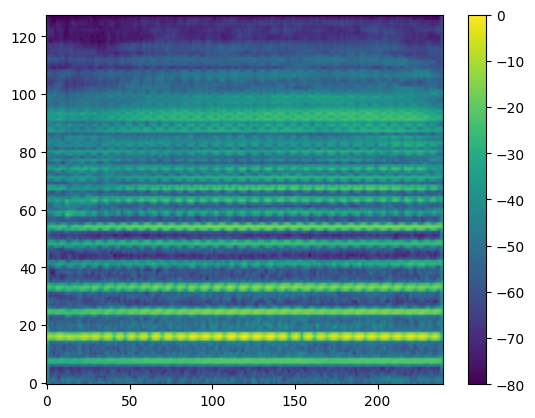

In [2]:
def audio_to_melspectrogram(audio, sr=22050):
    if isinstance(audio, str):  # If input is a file path
        y, sr = librosa.load(audio, sr=sr)
    else:  # If input is a NumPy array (live audio)
        y = audio
    
    y, _ = librosa.effects.trim(y, top_db=10) 
    y = librosa.util.normalize(y)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB
    return mel_spec_db

# Example usage
mel_spectrogram = audio_to_melspectrogram(r"H:\DSP_project\ignoredir\dataset\archive2\Train_submission\Train_submission\violin_sound (241).wav")
plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
plt.colorbar()
plt.show()


In [3]:
data_df = pd.read_csv("H:\DSP_project\model\jupyter\God_data.csv", index_col=0)
data_df = data_df.groupby('Class').apply(lambda x: x.sample(n=min(len(x), 250))).reset_index(drop=True)
data_df = data_df.drop_duplicates()

C:\Users\gotxz\AppData\Local\Temp\ipykernel_22800\3473824080.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_df = data_df.groupby('Class').apply(lambda x: x.sample(n=min(len(x), 250))).reset_index(drop=True)


In [ ]:
# onehot = OneHotEncoder(sparse_output=False)
# onehot.fit(data_df["Class"].unique().reshape(-1,1))

# map_index_class = {}
# for i in range(len(onehot.categories_[0])):
#     onehot_vec = [0]*28
#     onehot_vec[i] = 1
#     onehot_vec = [onehot_vec]
#     true_class = onehot.inverse_transform(onehot_vec)
#     map_index_class[i] = true_class[0][0]
#     print(i, true_class[0][0])
    

# with open("encoder.pkl", "wb") as f:
#     encoder = {"encoder" : onehot,
#                "map_index_class" : map_index_class}
#     pickle.dump(encoder, f)

In [4]:
with open(r"H:\DSP_project\model\jupyter\encoder.pkl", "rb") as f:
        encoder = pickle.load(f)
onehot = encoder["encoder"]
map_index_class = encoder["map_index_class"]

In [9]:
dull_df, test_df = train_test_split(data_df, test_size=0.1, random_state=42, shuffle=True)
train_df, val_df = train_test_split(dull_df, test_size=0.2, random_state=42, shuffle=True)

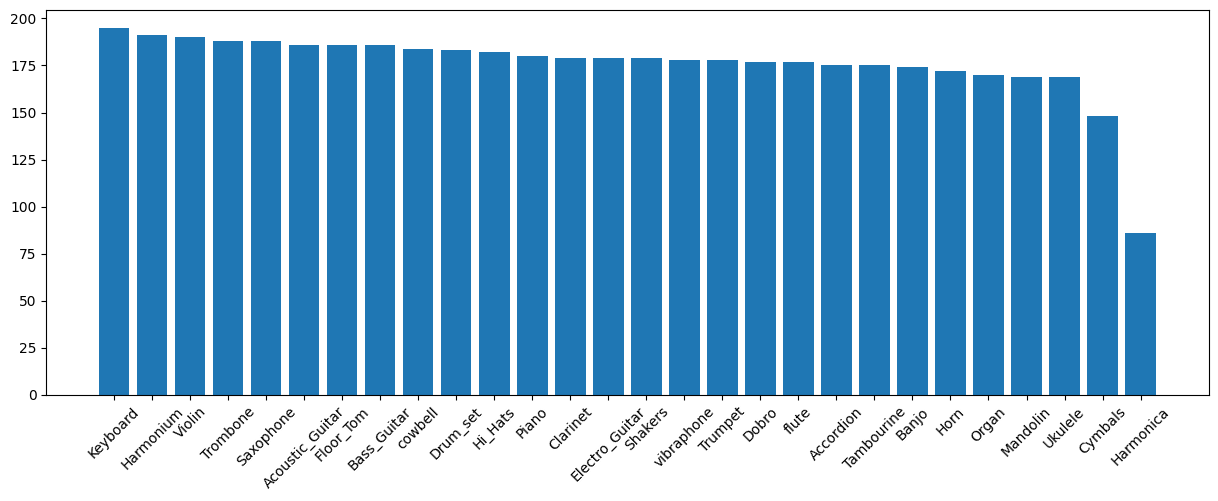

In [10]:
test = train_df.value_counts("Class")
plt.figure(figsize=(15,5))
plt.bar(test.index, test)
plt.xticks(rotation=45)
plt.show()

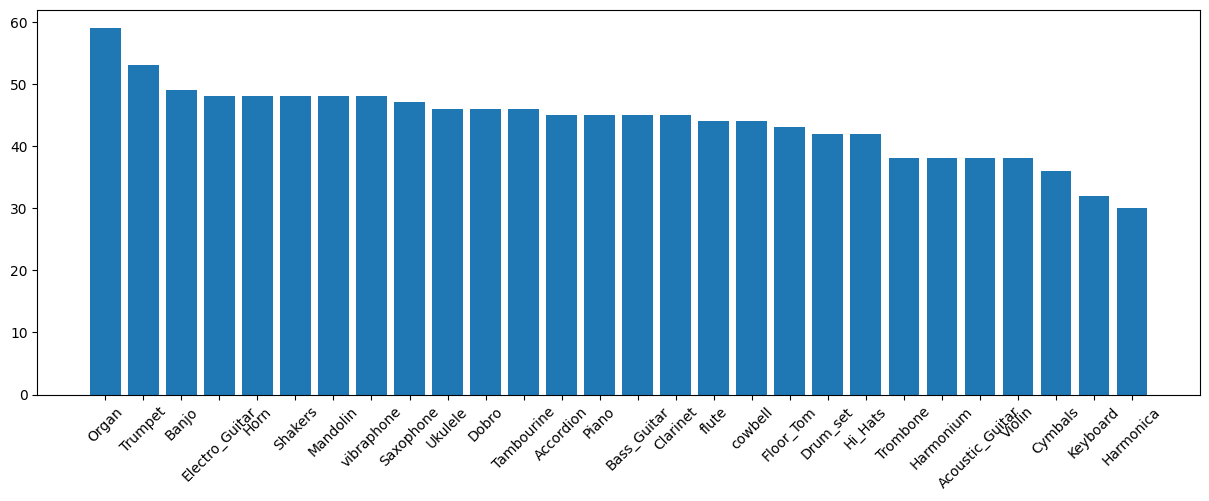

In [11]:
test = val_df.value_counts("Class")
plt.figure(figsize=(15,5))
plt.bar(test.index, test)
plt.xticks(rotation=45)
plt.show()

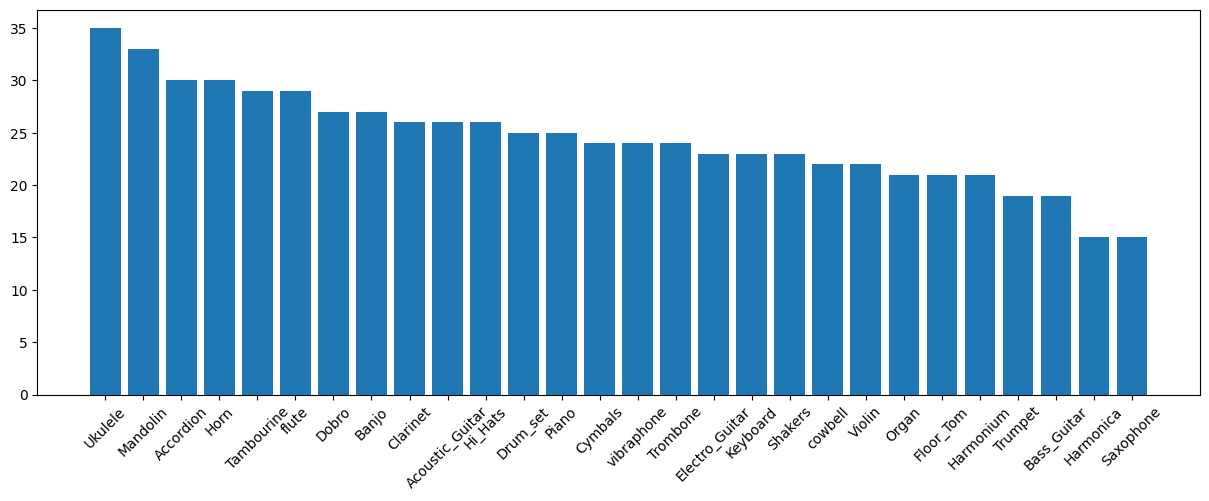

In [12]:
test = test_df.value_counts("Class")
plt.figure(figsize=(15,5))
plt.bar(test.index, test)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# train_dataset = InstrumentDataset(train_df, onehot)
# train_dataloader = DataLoader(train_dataset, batch_size=12288, shuffle=True)

# val_dataset = InstrumentDataset(val_df, onehot)
# val_dataloader = DataLoader(val_dataset, batch_size=12288, shuffle=True)

# test_dataset = InstrumentDataset(test_df, onehot)
# test_dataloader = DataLoader(test_dataset, batch_size=12288, shuffle=True)

# data = {
#     "train_dataset" : train_dataset,
#     "train_dataloader" : train_dataloader,
#     "val_dataset" : val_dataset,
#     "val_dataloader" : val_dataloader,
#     "test_dataset" : test_dataset,
#     "test_dataloader" : test_dataloader
#     }

# with open("data_model.pkl", "wb") as f:
#     pickle.dump(data, f)

In [2]:
with open(r"H:\DSP_project\model\jupyter\data_model.pkl", "rb") as f:
    data_mode = pickle.load(f)
    train_dataset = data_mode["train_dataset"]
    train_dataloader = data_mode["train_dataloader"]
    val_dataset = data_mode["val_dataset"],
    val_dataloader = data_mode["val_dataloader"],
    test_dataset = data_mode["test_dataset"]
    test_dataloader = data_mode["test_dataloader"]
    

In [18]:
def conv_output_size(input_width, input_height, kernel_size, stride, padding):
    """
    Calculate the output width and height of a convolutional layer.
    
    Parameters:
    - input_width: Width of the input (W_in)
    - input_height: Height of the input (H_in)
    - kernel_size: Size of the convolutional kernel (K_h, K_w)
    - stride: Stride of the convolution (S)
    - padding: Padding applied (P)
    
    Returns:
    - output_width: Width of the output (W_out)
    - output_height: Height of the output (H_out)
    """
    # Calculate output height and width using the formula
    output_height = (input_height - kernel_size + 2 * padding) // stride + 1
    output_width = (input_width - kernel_size + 2 * padding) // stride + 1
    
    return output_width, output_height

# Example usage:
input_width = 11
input_height = 64
kernel_size = 2
stride = 2
padding = 0

output_width, output_height = conv_output_size(input_width, input_height, kernel_size, stride, padding)

print(f"Output size: {output_width} x {output_height}")


Output size: 5 x 32


In [19]:
# Initialize model
model = InstrumentClassifier_CBAM(28)

# Check if GPU is available, if so move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print model summary
summary(model, input_size=(1, 22, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 22, 128]              80
         MaxPool2d-2            [-1, 8, 11, 64]               0
 AdaptiveAvgPool2d-3              [-1, 8, 1, 1]               0
            Conv2d-4              [-1, 1, 1, 1]               8
              ReLU-5              [-1, 1, 1, 1]               0
            Conv2d-6              [-1, 8, 1, 1]               8
           Sigmoid-7              [-1, 8, 1, 1]               0
            Conv2d-8            [-1, 1, 11, 64]              98
           Sigmoid-9            [-1, 1, 11, 64]               0
             CBAM-10            [-1, 8, 11, 64]               0
      BatchNorm2d-11            [-1, 8, 11, 64]              16
           Conv2d-12           [-1, 16, 11, 64]           1,168
        MaxPool2d-13            [-1, 16, 5, 32]               0
AdaptiveAvgPool2d-14             [-1, 1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(onehot.get_feature_names_out())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InstrumentClassifier_CBAM(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epoches = 200

train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_wts = None

for epoch in range(epoches):  # Train for 50 epochs
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    
    # Training phase
    batch = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        # print(f"epoch: {epoch}, batch: {batch}, loss: {loss:.2f}" )
        batch+=1
    
    # Average training loss for the epoch
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
    
    # Average validation loss for the epoch
    avg_val_loss = running_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)
    
    # Save the best model weights based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = model.state_dict()
    
    # Print loss statistics for this epoch
    print(f"Epoch {epoch+1}/{epoches}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Load best model weights (if training is stopped)
model.load_state_dict(best_model_wts)

# torch.save(model.state_dict(), "instrument_classifier_cbam_200_0.0001.pt")

In [ ]:
plt.plot(range(1, epoches+1), train_losses, label='Training Loss')
plt.plot(range(1, epoches+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

torch.Size([8165, 1, 128, 22])
Classification Report:
                  precision    recall  f1-score   support

      Accordion       0.91      0.78      0.84       306
Acoustic_Guitar       0.85      0.87      0.86       287
          Banjo       0.88      0.91      0.90       250
    Bass_Guitar       0.98      0.99      0.99       188
       Clarinet       0.95      0.97      0.96       245
        Cymbals       0.92      0.97      0.95       146
          Dobro       0.92      0.94      0.93       271
       Drum_set       0.94      0.87      0.91       398
 Electro_Guitar       0.84      0.89      0.87       237
      Floor_Tom       0.85      0.83      0.84        84
      Harmonica       0.99      0.98      0.99       111
      Harmonium       1.00      1.00      1.00       221
        Hi_Hats       0.84      0.94      0.89       189
           Horn       1.00      1.00      1.00       283
       Keyboard       1.00      1.00      1.00       248
       Mandolin       0.84      

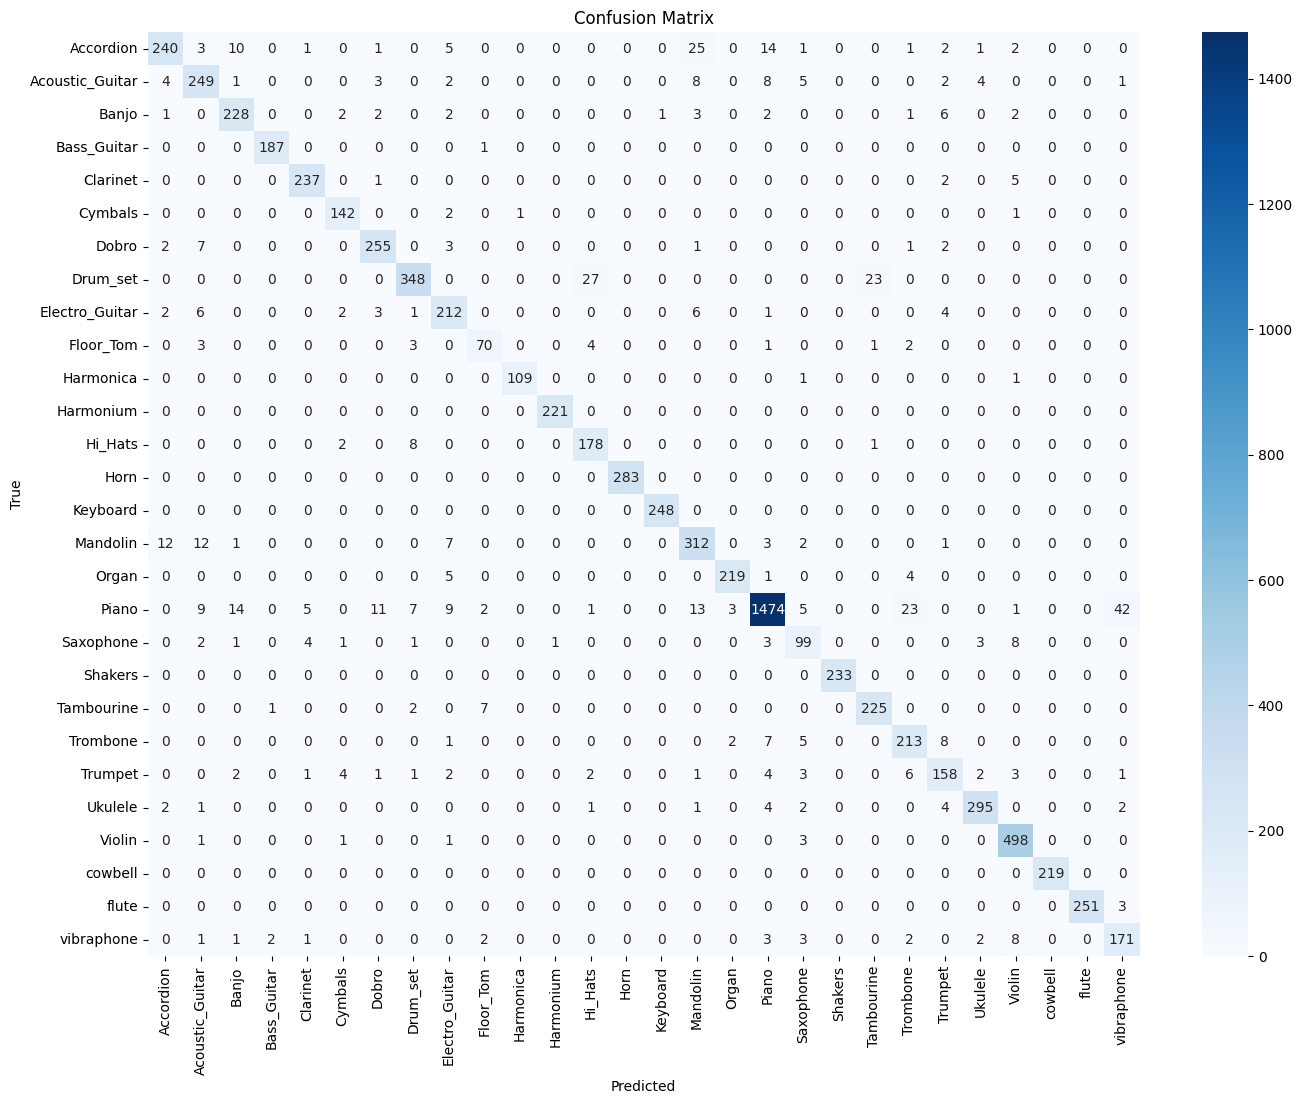

In [5]:

# Evaluate function with One-Hot Encoding and softmax
def evaluate_model(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to track gradients
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get raw logits from the model
            print(inputs.shape)
            outputs = model(inputs)  # Raw logits
            
            # Apply softmax to the logits to get probabilities
            probabilities = F.softmax(outputs, dim=1)
            
            # Convert probabilities to one-hot format
            preds = torch.argmax(probabilities, dim=1)  # Get the class index with highest probability
            one_hot_preds = torch.nn.functional.one_hot(preds, num_classes=probabilities.size(1))  # Convert to one-hot
            
            # Store predictions and labels for metrics calculation
            all_preds.extend(one_hot_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert all_preds and all_labels to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Decode the one-hot predictions and labels back to class labels
    
    predicted_labels = onehot.inverse_transform(all_preds)
    
    true_labels = onehot.inverse_transform(all_labels)
    
    # Classification report
    report = classification_report(true_labels, predicted_labels)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    return report, conf_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(16, 12))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = InstrumentClassifier_CBAM(28)
model.to(device)
model.load_state_dict(torch.load(r'H:\DSP_project\model\jupyter\instrument_classifier_cbam_200_0.0001_weight.pt'))

# Get classification report and confusion matrix
report, conf_matrix = evaluate_model(model, test_dataloader, device)

# Print the classification report
print("Classification Report:\n", report)

# Plot confusion matrix
class_names = onehot.categories_[0]
plot_confusion_matrix(conf_matrix, class_names)
